# Imports

- References:
    - [HLS: Your new favorite remote sensing dataset](https://hrodmn.dev/posts/hls/);
    - [2021 Cloud Hackathon](https://nasa-openscapes.github.io/2021-Cloud-Hackathon/);

In [1]:
%%time

import json
import warnings
import stackstac
import planetary_computer
import pystac_client

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from collections import defaultdict
from dask.diagnostics import ProgressBar
from shapely.geometry import Polygon
from rasterio.enums import Resampling
from rasterio import RasterioIOError

warnings.filterwarnings("ignore")

CPU times: user 2.56 s, sys: 361 ms, total: 2.92 s
Wall time: 3.24 s


# Connect to the NASA STAC

In [2]:
CMR_STAC_URL = "https://cmr.earthdata.nasa.gov/stac/LPCLOUD/"
catalog = pystac_client.Client.open(CMR_STAC_URL)

HLS_COLLECTION_IDS = ["HLSL30.v2.0", "HLSS30.v2.0"]

# Request

In [3]:
data_range = "2022-01-01/2022-04-01"

with open("../data/sao_paulo.json", "r") as f:
    input_data_geojson = json.load(f)

input_geometry = input_data_geojson["features"][0]["geometry"]
input_data_geojson

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {},
   'geometry': {'coordinates': [[[-47.4612944459833, -20.506547609902498],
      [-47.4612944459833, -20.576851324905675],
      [-47.34060235578002, -20.576851324905675],
      [-47.34060235578002, -20.506547609902498],
      [-47.4612944459833, -20.506547609902498]]],
    'type': 'Polygon'}}]}

# Explore Data

In [4]:
%%time

hls_history_search = catalog.search(
    collections=HLS_COLLECTION_IDS,
    intersects=input_geometry,
    limit=100
)

CPU times: user 28.6 ms, sys: 0 ns, total: 28.6 ms
Wall time: 251 ms


In [5]:
%%time

# Print out how many STAC Items match our search query
hls_history_search.matched()

CPU times: user 4.9 ms, sys: 6.92 ms, total: 11.8 ms
Wall time: 1.19 s


1336

In [6]:
%%time

# I am looping through the pages() because the NASA STAC connection can be flaky sometimes 
# and will give you 502 errors when you loop through a long list of items(). 
# I don’t know why the pages() method is more stable, but it seems to work better for 
# large queries like this.
all_items = []
for page in hls_history_search.pages():
    all_items.extend(page.items)

# Show some of them!
all_items[:10]

CPU times: user 1.87 s, sys: 82.3 ms, total: 1.96 s
Wall time: 1min 30s


[<Item id=HLS.L30.T22KHC.2013107T131133.v2.0>,
 <Item id=HLS.L30.T23KKT.2013107T131133.v2.0>,
 <Item id=HLS.L30.T23KKT.2013139T131145.v2.0>,
 <Item id=HLS.L30.T22KHC.2013139T131145.v2.0>,
 <Item id=HLS.L30.T23KKT.2013155T131147.v2.0>,
 <Item id=HLS.L30.T22KHC.2013155T131147.v2.0>,
 <Item id=HLS.L30.T22KHC.2013171T131139.v2.0>,
 <Item id=HLS.L30.T23KKT.2013171T131139.v2.0>,
 <Item id=HLS.L30.T23KKT.2013187T131143.v2.0>,
 <Item id=HLS.L30.T22KHC.2013187T131143.v2.0>]

In [7]:
collection_history = {
    collection: defaultdict(list) for collection in HLS_COLLECTION_IDS
}

collection_history

{'HLSL30.v2.0': defaultdict(list, {}), 'HLSS30.v2.0': defaultdict(list, {})}

In [8]:
%%time

for item in all_items:
    year_month = pd.Timestamp(item.datetime.date()) + pd.offsets.MonthEnd()
    entry = collection_history[item.collection_id][year_month]
    if (date := item.datetime.date()) not in entry:
        entry.append(date)

CPU times: user 57.2 ms, sys: 108 µs, total: 57.3 ms
Wall time: 57.2 ms


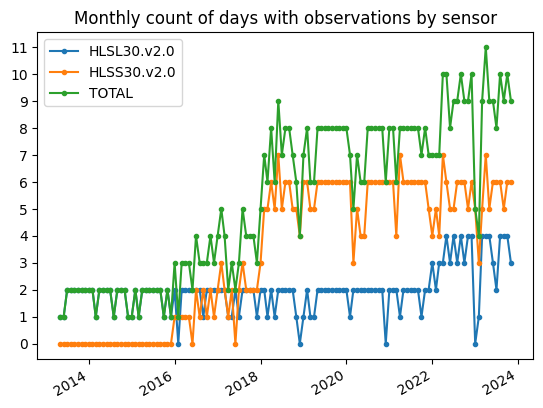

In [9]:
# Get count of images by year/month/sensor.
collection_counts = pd.DataFrame(
    {
        collection: {
            year_month: len(dates) for year_month, dates in year_months.items()
        }
        for collection, year_months in collection_history.items()
    }
).fillna(0)

collection_counts["TOTAL"] = collection_counts["HLSL30.v2.0"] + collection_counts["HLSS30.v2.0"]

_ = collection_counts.plot.line(
    title="Monthly count of days with observations by sensor",
    marker="."
)
plt.yticks(np.arange(12));

# Bands

![](../images/hls_bands.png)

In [10]:
BAND_CROSSWALK = {
    "HLSL30.v2.0": {
        "B01": "coastal aerosol",
        "B02": "blue",
        "B03": "green",
        "B04": "red",
        "B05": "nir narrow",
        "B06": "swir 1",
        "B07": "swir 2",
        "B09": "cirrus",
        "B10": "thermal infrared 1",
        "B11": "thermal",
    },
    "HLSS30.v2.0": {
        "B01": "coastal aerosol",
        "B02": "blue",
        "B03": "green",
        "B04": "red",
        "B05": "red-edge 1",
        "B06": "red-edge 2",
        "B07": "red-edge 3",
        "B08": "nir broad",
        "B8A": "nir narrow",
        "B09": "water vapor",
        "B10": "cirrus",
        "B11": "swir 1",
        "B12": "swir 2",
    },
}

# These are the ones that we are going to use.
BANDS = ["red", "green", "blue", "Fmask"]

# Make a Cloud-Free Mosaic

## Search the Stac

In [11]:
%%time

START_DATE = "2022-07-01"
END_DATE = "2022-07-31"

stac_items = catalog.search(
    collections=HLS_COLLECTION_IDS,
    intersects=input_geometry,
    datetime=[START_DATE, END_DATE],
    limit=100
).item_collection()

stac_items

CPU times: user 21.2 ms, sys: 12.2 ms, total: 33.4 ms
Wall time: 2.8 s


## Modify The Asset Labels

In [12]:
%%time

for item in stac_items:
    for original_band, new_band in BAND_CROSSWALK.get(item.collection_id).items():
        item.assets[new_band] = item.assets.pop(original_band)

stac_items

CPU times: user 213 µs, sys: 24 µs, total: 237 µs
Wall time: 245 µs


## Load Data

In [13]:
%%time

hls_stack_raw = stackstac.stack(
    stac_items,
    assets=BANDS,
    bounds_latlon=Polygon(input_geometry["coordinates"][0]).bounds,
    epsg=3857,
    resolution=30,
    xy_coords="center",
    # errors_as_nodata=(RasterioIOError("HTTP response code: 404"), Exception("*"), )
)

# Show it.
hls_stack_raw

CPU times: user 48.9 ms, sys: 0 ns, total: 48.9 ms
Wall time: 51.9 ms


<xarray.DataArray 'stackstac-3baaaa5c14dec276af14527ffe28c410' (time: 20,
                                                                band: 4,
                                                                y: 279, x: 449)>
dask.array<fetch_raster_window, shape=(20, 4, 279, 449), dtype=float64, chunksize=(1, 1, 279, 449), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 2022-07-03T13:28:02.091000 ... 2022...
    id              (time) <U34 'HLS.S30.T23KKT.2022184T132239.v2.0' ... 'HLS...
  * band            (band) <U5 'red' 'green' 'blue' 'Fmask'
  * x               (x) float64 -5.283e+06 -5.283e+06 ... -5.27e+06 -5.27e+06
  * y               (y) float64 -2.333e+06 -2.333e+06 ... -2.341e+06 -2.341e+06
    end_datetime    (time) <U24 '2022-07-03T13:28:02.091Z' ... '2022-07-31T13...
    eo:cloud_cover  (time) int64 0 0 39 22 1 0 10 17 3 1 0 4 0 0 0 0 1 1 0 0
    start_datetime  (time) <U24 '2022-07-03T13:28:02.091Z' ... '2022-07-31T13...
    epsg            int64 3857
Attributes:
    spec:        RasterSpec(epsg=3857, bounds=(-5283390, -2341500, -5269920, ...
    crs:         epsg:3857
    transform:   | 30.00, 0.00,-5283390.00|\n| 0.00,-30.00,-2333130.00|\n| 0....
    resolution:  30

## Cloud / Shadow Masking

![](../images/hls_masks.png)

In [14]:
hls_mask_bitfields = [1, 2, 3]  # Cloud shadow, adjacent to cloud shadow, cloud.
hls_bitmask = 0
for field in hls_mask_bitfields:
    hls_bitmask |= 1 << field

print(hls_bitmask)

14


In [15]:
fmask = hls_stack_raw.sel(band="Fmask").astype("uint16")
hls_bad = fmask & hls_bitmask

In [16]:
# Mask pixels where any one of those bits are set.
hls_masked = hls_stack_raw.where(hls_bad == 0)

hls_masked

<xarray.DataArray 'stackstac-3baaaa5c14dec276af14527ffe28c410' (time: 20,
                                                                band: 4,
                                                                y: 279, x: 449)>
dask.array<where, shape=(20, 4, 279, 449), dtype=float64, chunksize=(1, 1, 279, 449), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 2022-07-03T13:28:02.091000 ... 2022...
    id              (time) <U34 'HLS.S30.T23KKT.2022184T132239.v2.0' ... 'HLS...
  * band            (band) <U5 'red' 'green' 'blue' 'Fmask'
  * x               (x) float64 -5.283e+06 -5.283e+06 ... -5.27e+06 -5.27e+06
  * y               (y) float64 -2.333e+06 -2.333e+06 ... -2.341e+06 -2.341e+06
    end_datetime    (time) <U24 '2022-07-03T13:28:02.091Z' ... '2022-07-31T13...
    eo:cloud_cover  (time) int64 0 0 39 22 1 0 10 17 3 1 0 4 0 0 0 0 1 1 0 0
    start_datetime  (time) <U24 '2022-07-03T13:28:02.091Z' ... '2022-07-31T13...
    epsg            int64 3857
Attributes:
    spec:        RasterSpec(epsg=3857, bounds=(-5283390, -2341500, -5269920, ...
    crs:         epsg:3857
    transform:   | 30.00, 0.00,-5283390.00|\n| 0.00,-30.00,-2333130.00|\n| 0....
    resolution:  30

## Get the Cloud-Free Mosaic

In [17]:
%%time

with ProgressBar() as p:

    hls_cloud_free = hls_masked.resample(time="1M").median(skipna=True).compute()

[########################################] | 100% Completed | 78.13 s
CPU times: user 8.06 s, sys: 2.72 s, total: 10.8 s
Wall time: 1min 18s


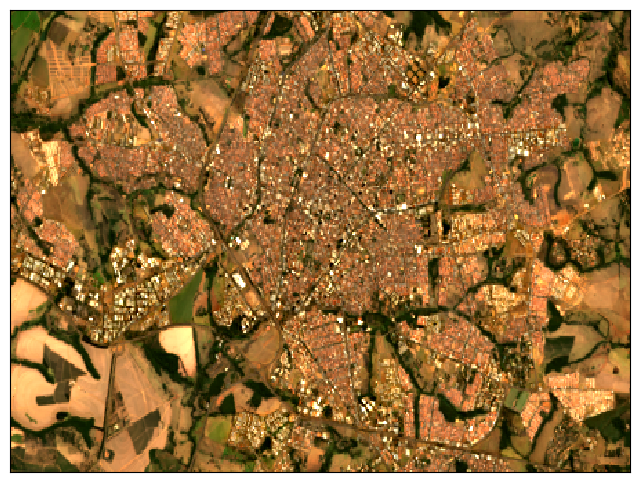

In [18]:
_ = (
    hls_cloud_free.isel(time=0)
    .sel(band=["red", "green", "blue"])
    .plot.imshow(
        rgb="band",
        robust=True,
        size=6,
        add_labels=False,
        xticks=[],
        yticks=[],
    )
)

# Compare to Sentinel 2 L2A and Landsat Collection 2 Level-2

In [19]:
planetary_computer_catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [20]:
%%time

sentinel_stac_items = planetary_computer_catalog.search(
    collections=["sentinel-2-l2a"],
    intersects=input_geometry,
    datetime=[START_DATE, END_DATE],
).get_all_items()

sentinel_band_crosswalk = {
    "B04": "red",
    "B03": "green",
    "B02": "blue",
}

for item in sentinel_stac_items:
    for original_band, new_band in sentinel_band_crosswalk.items():
        item.assets[new_band] = item.assets.pop(original_band)

sentinel_stack = stackstac.stack(
    items=sentinel_stac_items,
    assets=["red", "green", "blue", "SCL"],
    bounds_latlon=Polygon(input_geometry["coordinates"][0]).bounds,
    epsg=3857,
    resolution=30,
    xy_coords="center",
    resampling=Resampling.bilinear,
)

# Valid SCL values: 4: vegetation, 5: bare soils, 6: water, 11: snow or ice
# https://docs.digitalearthafrica.org/en/latest/data_specs/Sentinel-2_Level-2A_specs.html
valid_scl = [4, 5, 6, 11]

with ProgressBar() as p:

    sentinel_cloud_free = (
        sentinel_stack.where(sentinel_stack.sel(band="SCL").isin(valid_scl))
        .sel(band=["red", "green", "blue"])
        .resample(time="1M")
        .median(skipna=True)
        .compute()
    )

[########################################] | 100% Completed | 42.61 s
CPU times: user 10.7 s, sys: 1.04 s, total: 11.8 s
Wall time: 44.5 s


In [21]:
%%time

landsat_stac_items = planetary_computer_catalog.search(
    collections=["landsat-c2-l2"],
    intersects=input_geometry,
    datetime=[START_DATE, END_DATE],
    query={"platform": {"neq": "landsat-7"}},  # Skip Landsat 7 because stripes!
).get_all_items()

landsat_stack = stackstac.stack(
    items=landsat_stac_items,
    assets=["red", "green", "blue", "qa_pixel"],
    bounds_latlon=Polygon(input_geometry["coordinates"][0]).bounds,
    epsg=3857,
    resolution=30,
    xy_coords="center",
    band_coords=False,
)

# Following https://stackstac.readthedocs.io/en/latest/examples/gif.html#Mask-cloudy-pixels-using-the-QA-band:
# Make a bitmask---when we bitwise-and it with the data, it leaves just the 4 bits we care about
mask_bitfields = [1, 2, 3, 4]  # Dilated cloud, cirrus, cloud, cloud shadow.
bitmask = 0
for field in mask_bitfields:
    bitmask |= 1 << field

landsat_qa = landsat_stack.sel(band="qa_pixel").astype("uint16")
landsat_bad = landsat_qa & bitmask  # Just look at those 4 bits.

landsat_good = landsat_stack.where(
    landsat_bad == 0
)  # Mask pixels where any one of those bits are set.

with ProgressBar() as p:

    landsat_cloud_free = (
        landsat_good.sel(band=["red", "green", "blue"])
        .resample(time="1M")
        .median(skipna=True)
        .compute()
    )

[########################################] | 100% Completed | 9.39 ss
CPU times: user 1.85 s, sys: 184 ms, total: 2.03 s
Wall time: 10.7 s


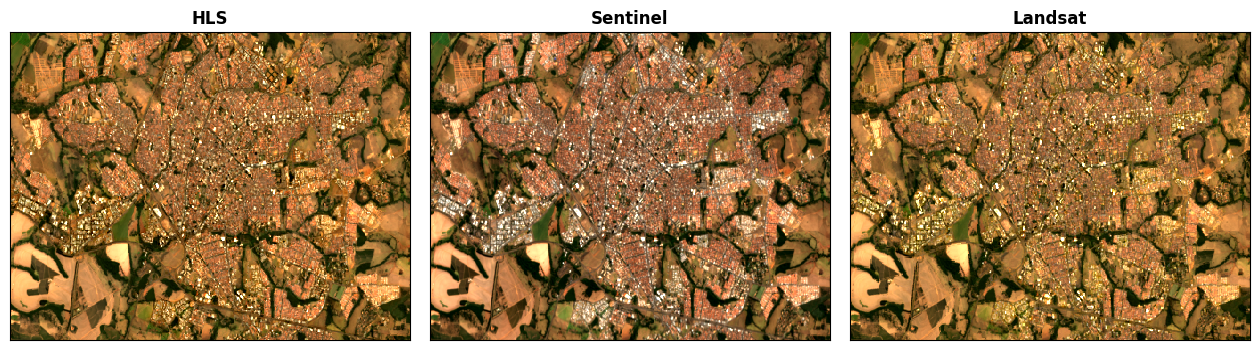

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

_ = (
    hls_cloud_free.isel(time=0)
    .sel(band=["red", "green", "blue"])
    .plot.imshow(
        rgb="band",
        robust=True,
        add_labels=False,
        xticks=[],
        yticks=[],
        ax=ax[0]
    )
)

_ = (
    sentinel_cloud_free.isel(time=0)
    .sel(band=["red", "green", "blue"])
    .plot.imshow(
        rgb="band",
        robust=True,
        add_labels=False,
        xticks=[],
        yticks=[],
        ax=ax[1]
    )
)

_ = (
    landsat_cloud_free.isel(time=0)
    .sel(band=["red", "green", "blue"])
    .plot.imshow(
        rgb="band",
        robust=True,
        add_labels=False,
        xticks=[],
        yticks=[],
        ax=ax[2]
    )
)

plt.subplots_adjust(wspace=0.05)
ax[0].set_title("HLS", weight="bold")
ax[1].set_title("Sentinel", weight="bold")
_ = ax[2].set_title("Landsat", weight="bold");